## Reverse Answer Rank Algorithm by Using Data Science

**USE CASE:** 

Quora creates an algorithm to rank the answers on a page, the assumption is that Quora uses a wide variety of factors to determinate which anwser should be ranked higher or lower. So the question comes to my mind is what does the rank depend on? What's the secret source?

Let's take the advantage of data science technology to reverse the ranking algorithm as much as possible!

**SOLUTION:** 
1. Crawl all of the urls to question from a certain topic;
2. Extract all of available attributes associated with those questions and users who answered;
3. Analyze and explore the dataset to identify the rank signals;
4. Build the machine learning models to predict ranking based on certain inputs.

At this point, let's get started with this topic [Python (programming language)](https://www.quora.com/topic/Python-programming-language-1): https://www.quora.com/topic/Python-programming-language-1

**GOALS:** 

The goal of this analysis will be able to anwser the following questions:
* What does the anwser ranking depend on? (e.g The longer content helps the anwser rank higher)
* If the author does XYZ things on their anwser, what's the expected rank # going to be for specific question (e.g. Refresh the content more recently)

**RESULTS:**

1. Be able to build a simple and decent Generalized Linear Model to predict the rank based on the combination of 10+ features. The R2 for test dataset is oftent around 0.4, which captures 40% of prediction information.
2. The key rank signals seems to be content length, # of upvotes, freshness and user's authority. The can be represnted by individual features.
3. We can see the sample size to be analyzed is <= 30 when break down to the anwsers by each rank This tens to be noisy and not statistically meaningful.
4. Implemented the Tnesorflow Linear model as well.

**NEXT:**

1. Tune the parameters and implement other machine learning algorithm (e.g. Random Forest, GLMM and Deep Neural Networks) in order to find the best models
2. Compute feature importace and test statistics hypothesis
3. Consider collecting more data points in two ways: increase sample size and expand the feature columns
4. Investigate if there're any low quality course (spam) get higher rank.
5. Monitor how do these factors change over time and wisualize the metrics by Kibana 

**DISCLAIMER:**
1. The dataset we use for this notebook is to aim to do a data scinece work, kind of academic and research, it doens't have any iscommercial purposes.
2. The action of getting those public data for this project also follows the rules that's described by Quora's terms of service page: https://www.quora.com/about/tos
3. Please reach out me by if you have any questions and concerns

***REFRENCE:***
* *https://engineering.quora.com/A-Machine-Learning-Approach-to-Ranking-Answers-on-Quora*
* *https://balajiviswanathan.quora.com/Power-User-Tips-Reverse-Engineering-the-Quoras-Answer-Ranking-Algorithm*
* *https://www.quora.com/How-does-the-ranking-of-answers-on-Quora-work*

In [2]:
"""
1. quora is a customized python moudle to deal with the data manipulation for this dataset 
2. pystats is a high level package that I built on top of a range of statsitics open source
"""
import quora
from quora import QuoraClient, ElasticSearchClient

import numpy as np
import pystats as ps
from pystats.models import Model, ModelSetting, LinearRegressorModel, TreeRegressorModel
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Crawl Topic Page

In [8]:
"""
Set up a Quora client
"""
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.1 Safari/537.36'
qc = QuoraClient(user_agent=user_agent)

# print user agent to check
qc.print_user_agent()

"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.1 Safari/537.36"


In [3]:
"""
1. Visit the python topic
2. Extract the links to question from topic
3. Save to local file - questions.txt
"""

topic_seed = 'https://www.quora.com/topic/Python-programming-language-1'
question_urls_file_path = 'data/questions.txt'

question_links_gen = qc.get_questions_from_single_topic(topic_seed)

if False:
    quora.write_content_to_file(question_urls_file_path, '\n'.join(set(question_links_gen)))

In [8]:
# Retrive the questions from the file
questions = quora.get_questions_list(question_urls_file_path)

In [9]:
len(questions)

76

### Crawl Question Page

In [4]:
"""
Login Quora
"""
email, password = quora.get_credential(config='conf.yaml')
qc.login(email, password)

In [17]:
# crawl all of questions urls and save to local

questions_dir = 'data/questions/'
if False:
    qc.crawl(questions, save_dir=questions_dir, max_scroll_down_times=2000)
    # test single url
    # qc.crawl(['https://www.quora.com/Can-C-do-everything-that-Python-can'],save_dir=questions_dir, max_scroll_down_times=200)

In [18]:
"""
Identify the final list of questions that are qualified
"""
question_files = quora.list_all_files(questions_dir)
#htmls = quora.get_all_htmls(files)

def final_questions_gen():
    for file in question_files:
        html = quora.read_content_from_file(file)
        soup = quora.create_soup(html)
        answer_count = int(soup.find('div', attrs={'class': 'answer_count'}).text.split()[0].rstrip('+'))
        items = soup.find_all('div', attrs={'class': 'Answer AnswerBase'})
        if len(items) == answer_count:
            yield file
            
final_questions = list(final_questions_gen())
final_questions_file_path = 'data/final_questions.txt'
quora.write_content_to_file(final_questions_file_path, '\n'.join(final_questions))

In [19]:
len(final_questions)

32

In [51]:
final_question_htmls = []
with open(final_questions_file_path, 'r+', encoding='utf-8') as f:
    for line in f.readlines():
        line = line.rstrip('\n')
        final_question_htmls.append(quora.read_content_from_file(line))
    f.close()

In [52]:
len(final_question_htmls)

32

### Crawl Users Profile

In [21]:
users_file_path = 'data/final_users.txt'

In [35]:
def final_users_gen():
    for html in final_question_htmls:
        soup = quora.create_soup(html)
        answer_count = int(soup.find('div', attrs={'class': 'answer_count'}).text.split()[0].rstrip('+'))
        items = soup.find_all('div', attrs={'class': 'Answer AnswerBase'})
        for item in items:
            profile_link = item.find('a', attrs={'class':'user'})
            if profile_link is not None:
                yield qc.quora_homepage + profile_link['href']

quora.write_content_to_file(users_file_path, '\n'.join(set(final_users_gen())))

In [22]:
user_urls = []
with open(users_file_path, 'r+', encoding='utf-8') as f:
    for line in f.readlines():
        line = line.rstrip('\n')
        user_urls.append(line)
    f.close()

In [23]:
len(user_urls)

625

In [20]:
# crawl all of users urls and save to local
users_dir = 'data/users/'
if False:
    qc.crawl(user_urls, save_dir=users_dir, sleep=4, max_scroll_down_times=3)

In [24]:
users_mapping = dict()

for url in user_urls:
    users_mapping[quora.to_hash(url)] = url

In [9]:
qc.shutdown()

### Save Data to ElasticSearch

In [6]:
esc = ElasticSearchClient()

In [7]:
es = esc.connect()

Connected!


In [8]:
es.info()

{'cluster_name': 'elasticsearch',
 'cluster_uuid': 'TQpMsFbbQXqm1t3GKLDoeA',
 'name': '0pcvYyN',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2018-08-17T23:18:47.308994Z',
  'build_flavor': 'default',
  'build_hash': '595516e',
  'build_snapshot': False,
  'build_type': 'zip',
  'lucene_version': '7.4.0',
  'minimum_index_compatibility_version': '5.0.0',
  'minimum_wire_compatibility_version': '5.6.0',
  'number': '6.4.0'}}

In [5]:
esc.is_exist(es, 'quora_user')

True

In [9]:
esc.create_mapping(es, quora.load_es_mapping(type='anwser'), index_name='quora_answer')

True

In [8]:
%time
esc.bulk(es, quora.users_info_gen(), index='quora_user', doc_type='quora_user')

Wall time: 0 ns


In [10]:
%time
esc.bulk(es, quora.answers_info_gen(), index='quora_answer', doc_type='quora_answer')

Wall time: 0 ns


### Load Data

In [9]:
"""
1. Export the dataset from the ElasticSearch index
2. Join anwsers and users table
3. Feature engineering (The detailed code is in quora module)
"""


users_data = esc.to_table_from_index(es, index_name='quora_user')
answers_data = esc.to_table_from_index(es, index_name='quora_answer')

users_table = quora.build_user_table(users_data)
answers_table = quora.build_anwser_table(answers_data)

In [10]:
users_data.head(2)

,answer_views,answer_views_this_month,answers,followers,following,posts,questions,topics,user_file_name,user_url
0,78k answer views,5.8k this month,166,22,0,0,6,16,data/users/015b508f9640597ac2f0919535c275d2.txt,https://www.quora.com/profile/Charles-H-Luck
1,188.5k answer views,25.3k this month,412,67,0,0,0,78,data/users/00f7094b13ba7988fcc34a2ffd5a60e0.txt,https://www.quora.com/profile/Apoorva-Roy-7


In [11]:
users_table.head(2)

,user_url,answer_views,answer_views_this_month,answers,followers,following,posts,questions,topics
0,https://www.quora.com/profile/Charles-H-Luck,78000,5800,166,22,0,0,6,16
1,https://www.quora.com/profile/Apoorva-Roy-7,188500,25300,412,67,0,0,0,78


In [12]:
users_table.info()

<class 'pystats.ops.table.PyTable'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 9 columns):
user_url                   625 non-null object
answer_views               625 non-null int64
answer_views_this_month    625 non-null int64
answers                    625 non-null int64
followers                  625 non-null int64
following                  625 non-null int64
posts                      625 non-null int64
questions                  625 non-null int64
topics                     625 non-null int64
dtypes: int64(8), object(1)
memory usage: 44.0+ KB


In [13]:
answers_data.head(2)

,answer_date,answers,author,content,crawled_date,created_date,number_of_a_tags,number_of_images,question,question_url,rank,upvotes,user_url,views
0,"Answered Oct 9, 2016",100,Kenneth Goodman,Stanford put out a great Python tutorial with ...,2018-09-26,2018-09-26,8,0,My boss gave me 30 days (not working days) to ...,https://www.quora.com/My-boss-gave-me-30-days-...,5,743,https://www.quora.com/profile/Kenneth-Goodman-4,104.4k
1,Answered Mar 2,100,Stephen M Greenfield,Although there’s a lot of great answers about ...,2018-09-26,2018-09-26,0,0,My boss gave me 30 days (not working days) to ...,https://www.quora.com/My-boss-gave-me-30-days-...,13,3,https://www.quora.com/profile/Stephen-M-Greenf...,1.3k


In [14]:
answers_table.head(2)

,question_url,user_url,answers,rank,number_of_a_tags,number_of_images,views,upvotes,content_word_count,days_since_last_modified
0,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Kenneth-Goodman-4,100,5,8,0,104400,743,270,717
1,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Stephen-M-Greenf...,100,13,0,0,1300,3,275,208


In [15]:
answers_data.info()

<class 'pystats.ops.table.PyTable'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 14 columns):
answer_date         672 non-null object
answers             672 non-null int64
author              668 non-null object
content             672 non-null object
crawled_date        672 non-null object
created_date        672 non-null object
number_of_a_tags    672 non-null int64
number_of_images    672 non-null int64
question            672 non-null object
question_url        672 non-null object
rank                672 non-null int64
upvotes             672 non-null object
user_url            668 non-null object
views               672 non-null object
dtypes: int64(4), object(10)
memory usage: 73.6+ KB


In [16]:
"""
Join two table

"""
data = answers_table.merge(users_table, how='left', left_on=['user_url'], 
                           right_on=['user_url'], suffixes=('_of_question', '_of_user'))

# take the log of the rank numner becasue we need to apply to GLM in the following (rank is always non-negative)
data['rank_log'] = data['rank'].apply(np.log10)

### EDA

In [17]:
data.head()

,question_url,user_url,answers_of_question,rank,number_of_a_tags,number_of_images,views,upvotes,content_word_count,days_since_last_modified,answer_views,answer_views_this_month,answers_of_user,followers,following,posts,questions,topics,rank_log
0,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Kenneth-Goodman-4,100,5,8,0,104400,743,270,717,181900.0,6100.0,68.0,140.0,1.0,1.0,1.0,33.0,0.698970
1,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Stephen-M-Greenf...,100,13,0,0,1300,3,275,208,526800.0,12100.0,41.0,144.0,97.0,0.0,5.0,40.0,1.113943
2,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Debanjan-Sengupta-7,100,1,2,0,15600,46,267,489,0.0,0.0,229.0,1036.0,1529.0,0.0,111.0,797.0,0.000000
3,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Siddharth-Dikshit-1,100,7,1,0,1300,3,183,216,2800.0,162.0,12.0,49.0,76.0,0.0,0.0,94.0,0.845098
4,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Bob-Jones-38,100,15,0,0,1000,6,455,94,901000.0,2300.0,89.0,881.0,29.0,0.0,13.0,25.0,1.176091


In [18]:
data.columns

Index(['question_url', 'user_url', 'answers_of_question', 'rank',
       'number_of_a_tags', 'number_of_images', 'views', 'upvotes',
       'content_word_count', 'days_since_last_modified', 'answer_views',
       'answer_views_this_month', 'answers_of_user', 'followers', 'following',
       'posts', 'questions', 'topics', 'rank_log'],
      dtype='object')

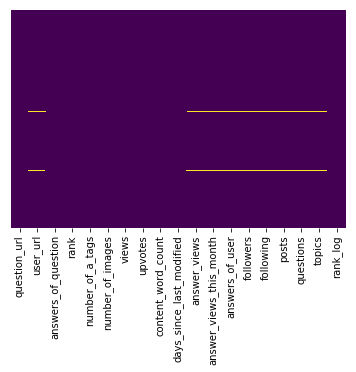

In [19]:
# check the null value
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

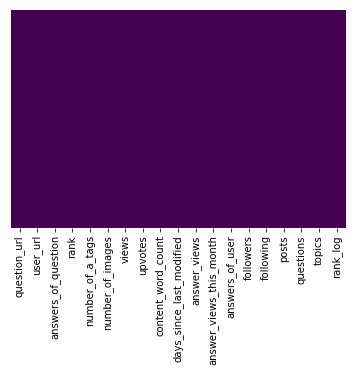

In [20]:
data = data[data['user_url'].apply(quora.is_not_none)]
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [21]:
data.shape

(668, 19)

In [22]:
# data = ps.TableQuery(data).select() \
# .where(query='question_url=https://www.quora.com/My-boss-gave-me-30-days-not-working-days-to-learn-Python-to-transfer-to-the-Data-Science-team-What-is-the-best-approach-to-learn-as-much-as-possible') \
# .execute()

In [23]:
data = ps.TableQuery(data).select() \
.andWhere(query='rank<=20') \
.andWhere(query='answers_of_question>=20') \
.execute()

In [24]:
ps.TableQuery(data).select(['views']).groupBy(['rank'], ['mean', 'count']).execute()

,rank,views_mean,views_count
0,1,66418.181818,11
1,2,9240.727273,11
2,3,55671.636364,11
3,4,102930.000000,10
4,5,81621.727273,11
5,6,11400.363636,11
6,7,7559.636364,11
7,8,5465.545455,11
8,9,2027.818182,11
9,10,7028.454545,11


In [25]:
data.head()

,question_url,user_url,answers_of_question,rank,number_of_a_tags,number_of_images,views,upvotes,content_word_count,days_since_last_modified,answer_views,answer_views_this_month,answers_of_user,followers,following,posts,questions,topics,rank_log
0,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Kenneth-Goodman-4,100,5,8,0,104400,743,270,717,181900.0,6100.0,68.0,140.0,1.0,1.0,1.0,33.0,0.698970
1,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Stephen-M-Greenf...,100,13,0,0,1300,3,275,208,526800.0,12100.0,41.0,144.0,97.0,0.0,5.0,40.0,1.113943
2,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Debanjan-Sengupta-7,100,1,2,0,15600,46,267,489,0.0,0.0,229.0,1036.0,1529.0,0.0,111.0,797.0,0.000000
3,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Siddharth-Dikshit-1,100,7,1,0,1300,3,183,216,2800.0,162.0,12.0,49.0,76.0,0.0,0.0,94.0,0.845098
4,https://www.quora.com/My-boss-gave-me-30-days-...,https://www.quora.com/profile/Bob-Jones-38,100,15,0,0,1000,6,455,94,901000.0,2300.0,89.0,881.0,29.0,0.0,13.0,25.0,1.176091


In [26]:
data.corr()

,answers_of_question,rank,number_of_a_tags,number_of_images,views,upvotes,content_word_count,days_since_last_modified,answer_views,answer_views_this_month,answers_of_user,followers,following,posts,questions,topics,rank_log
answers_of_question,1.000000,-0.003622,0.291532,0.024016,0.050191,-0.037702,0.318347,0.161948,-0.041755,-0.081260,-0.117952,0.080492,-0.037349,-0.072027,0.039331,0.005817,-0.002961
rank,-0.003622,1.000000,-0.223450,-0.167769,-0.238623,-0.239928,-0.518002,0.061853,-0.041988,-0.027491,0.025558,-0.062926,-0.015780,-0.033234,-0.003154,-0.038038,0.931071
number_of_a_tags,0.291532,-0.223450,1.000000,0.096034,-0.000433,0.037434,0.144626,-0.023691,-0.015658,-0.019419,-0.044713,0.029987,0.078208,-0.004870,0.105238,0.064598,-0.233609
number_of_images,0.024016,-0.167769,0.096034,1.000000,0.046739,0.101379,0.143634,-0.057421,0.081307,0.021725,0.025206,0.074391,0.005334,0.068929,0.023201,0.060599,-0.176138
views,0.050191,-0.238623,-0.000433,0.046739,1.000000,0.727598,0.217185,0.071265,0.309308,0.276040,0.265284,0.114089,0.029561,0.001100,-0.016529,-0.009868,-0.244259
upvotes,-0.037702,-0.239928,0.037434,0.101379,0.727598,1.000000,0.077681,0.057816,0.305192,0.277837,0.252313,0.137625,0.033569,0.000642,-0.013022,-0.003068,-0.266061
content_word_count,0.318347,-0.518002,0.144626,0.143634,0.217185,0.077681,1.000000,0.063732,-0.093961,-0.092203,-0.136644,-0.055206,-0.045763,-0.034061,-0.052078,-0.014155,-0.551675
days_since_last_modified,0.161948,0.061853,-0.023691,-0.057421,0.071265,0.057816,0.063732,1.000000,-0.027276,-0.072192,-0.023672,0.018449,0.108924,0.166804,0.127456,0.123696,0.063791
answer_views,-0.041755,-0.041988,-0.015658,0.081307,0.309308,0.305192,-0.093961,-0.027276,1.000000,0.933035,0.907499,0.592935,0.241755,0.178417,0.172900,0.106909,-0.010615
answer_views_this_month,-0.081260,-0.027491,-0.019419,0.021725,0.276040,0.277837,-0.092203,-0.072192,0.933035,1.000000,0.930716,0.462010,0.166333,0.103131,0.070499,0.072458,-0.015318


In [27]:
data.shape

(219, 19)

In [28]:
"""
1. Select a list of features as predictor input
2. Assign a variable to be target as output
"""

predictors = [
 #   'answers_of_question',
    'number_of_a_tags', 
    'number_of_images', 
    'views', 
    'upvotes',
    'content_word_count', 
    'days_since_last_modified', 
    'answer_views',
    'answer_views_this_month', 
    'answers_of_user', 
    'followers', 
    'following',
    'posts', 
    'questions', 
    'topics'
]

target = 'rank_log'

 ### Build Model - GLM

In [29]:
"""
1. Pass the model parameters to the model settings
2. Build a Linear Regression Model instance
3. Train and test the data
"""

setting = ModelSetting.create() \
.add(ModelSetting.TRAINING_SIZE, 0.8) \
.add(ModelSetting.SEED, 77) \
.add(ModelSetting.MODEL_NAME, Model.LINEAR_REGRESSION) \
.add(ModelSetting.ALPAH, 0.5) \
.add(ModelSetting.PREDICTORS, predictors) \
.add(ModelSetting.TARGET, target) \
.setup()

In [30]:
model = LinearRegressorModel(data, setting)

In [31]:
# Train the model
model.train()

In [32]:
model.model_performance()

{'alpha': 0.5,
 'model_name': 'Linear Regression',
 'predictors': 'number_of_a_tags,number_of_images,views,upvotes,content_word_count,days_since_last_modified,answer_views,answer_views_this_month,answers_of_user,followers,following,posts,questions,topics',
 'seed': 77,
 'target': 'rank_log',
 'train_mse': 0.06256332727522736,
 'train_r2': 0.4303216739898622,
 'train_rmse': 0.25012662248394785,
 'training_size': 0.8}

In [33]:
model.evaluate()

In [34]:
model.test_report.show()

Mean Squared Error: 0.11099792267975574
Root Mean Squared Error: 0.3331635074250416
R2 Score: 0.2564968188714294


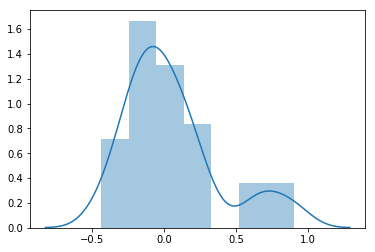

In [35]:
# check the distribution of difference between actual data and predicted data without transforming to orignal rank
sns.distplot(model.predict(model.X_test)-model.y_test)
plt.show()

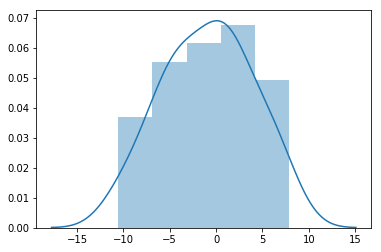

In [36]:
# check the distribution of difference between actual data and predicted data with transforming to orignal rank
sns.distplot(model.predict(model.X_test).apply(lambda x: np.power(10,x))-model.y_test.apply(lambda x: np.power(10,x)))
plt.show()

### Prediction

In [100]:
'''
Prediction for a certain question
'''

question = data.sample(1)
question

,question_url,user_url,answers_of_question,rank,number_of_a_tags,number_of_images,views,upvotes,content_word_count,days_since_last_modified,answer_views,answer_views_this_month,answers_of_user,followers,following,posts,questions,topics,rank_log
42,https://www.quora.com/Why-is-artificial-intell...,https://www.quora.com/profile/Michael-Lange-40,29,11,0,0,280,1,178,81,25900.0,3500.0,234.0,32.0,0.0,0.0,0.0,89.0,1.041393


In [101]:
print('Actual Rank={}'.format(question['rank'].values[0]))
print('Predicted Rank={:.2f}'.format(model.predict(question).apply(lambda x: np.power(10,x)).values[0]))

Actual Rank=11
Predicted Rank=9.09


In [56]:
'''
Prediction for a certain question
'''

question2 = model.test_data.sample(1)
question2

,number_of_a_tags,number_of_images,views,upvotes,content_word_count,days_since_last_modified,answer_views,answer_views_this_month,answers_of_user,followers,following,posts,questions,topics,rank_log
49,0,0,3500,15,133,198,439500.0,6800.0,118.0,113.0,13.0,0.0,1.0,19.0,1.0


In [57]:
print('Actual Rank={}'.format(question2['rank_log'].apply(lambda x: np.power(10,x)).values[0]))
print('Predicted Rank={:.2f}'.format(model.predict(question2).apply(lambda x: np.power(10,x)).values[0]))

Actual Rank=10.0
Predicted Rank=10.40
